# Электронное голосование 2020

Расшифрованные данные загружены из ноды наблюдателя и выполнена предварительная обработка:

```bash
{ cat ballots-header; cat ballots_decrypted_2020-07-01T19\ 47\ 00.csv | sed -n 's/#//g; 2~1p;'; } | \
    mlr --csv --fs ';' cut -f ballotId,districtId,blockId,time,decrypted > ballots.csv
```

При обработке из номера блока убирается символ `#`, чтобы номер читался как число; заменяются названия столбцов на более удобные; выбираются только те столбцы, которые необходимы для анализа. Для подготовки нужны стандартные утилиты `cat`, `sed` и утилита [mlr](https://johnkerl.org/miller/doc/index.html) для работы с табличными данными.

Подготовленные данные сохранены в файл `ballots.csv`. Для анализа будет использоваться набор библиотек [tidyverse](https://tidyverse.org).

In [ ]:
library(tidyverse)

In [ ]:
# Загружаем данные с указанием типов столбцов
df <- read_csv2("ballots.csv",
                col_types = "ifitf") %>%
  # сортируем по номеру блока
  arrange(blockId) %>%
  # заменяем идентификаторы опций на названия
  mutate(decrypted = factor(case_when(decrypted == "2212294583" ~ "yes",
                                      decrypted == "450215437"  ~ "no",
                                      is.na(decrypted) ~ "wrong")))

In [ ]:
# Группируем данные по блокам, регионам и выбору, подсчитаем сумму
agr <- df %>%
  group_by(blockId,districtId,decrypted) %>%
  summarise(n = n()) %>%
  ungroup()

Каждый блок генерируется раз в определённое количество времени. Поэтому номер блока примерно соответствует моменту времени. Сгруппировав голоса по блокам, мы можем оценить, как проходило голосование.

## Распределение голосов во времени

Построим график зависимости голосов от времени, каждому блоку соответствует две точки - одна для голосов "за", другая - для голосов "против". На этом графике можно увидеть, верна ли гипотеза о том, что голосовавшие электронно, в основном делали это в первые несколько дней.

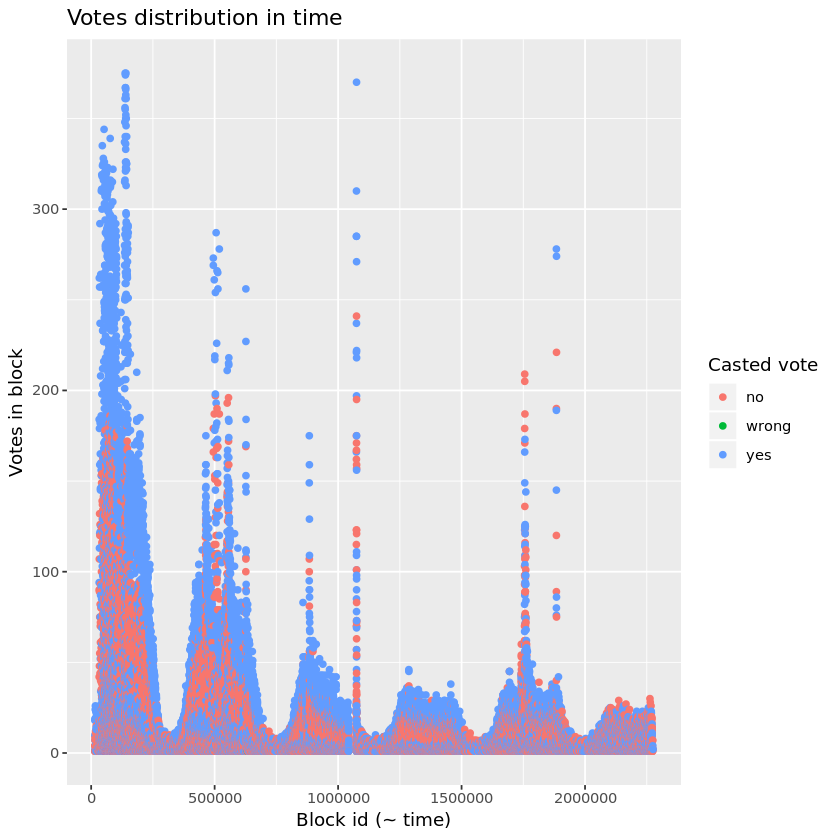

In [8]:
ggplot(agr) +
  geom_point(aes(blockId, n, colour = decrypted)) +
  labs(x = "Block id (~ time)", y = "Votes in block", "colour" = "Casted vote") +
  ggtitle("Votes distribution in time")

На графике видно, что основная масса проголосовала в первые два-три дня, но голосовали и в оставшиеся дни. Также заметна разница между дневным и ночным временем. Также интересно, что ночью активность голосования хоть и снижалась, но не падала до нуля.

Также заметны некоторые "всплески" --- участки, где количество голосов в блоке поднимается до нескольких сотен (вместо обычных десятков).

Если увеличить картинку и рассмотреть участки перед "всплесками" (например, между блоками 140000 и 150000, между блоками 500000 и 520000 и т.д.), можно увидеть, что в некотором промежутке блоков нет голосов. 

Возможно, в это время просто не было голосующих. Впрочем, судя по тому, что в соседних блоках голоса есть, а также по всплескам количества голосов после таких промежутков, логичнее предположить, что запись в блокчейн в это время по какой-то причине не работала. Учитывая, что после промежутков неактивности наблюдаются всплески, голоса всё же не пропадали.

Было бы интересно также проанализировать, удавалось ли системе выдать бюллетень в это время (записать факт выдачи в блокчейн) и если нет - каково было её поведение. Для этого необходима запись транзакций из системы. Надеюсь, команда ДЭГ её выложит (а если нет --- не будет препятствовать её изучению в ноде наблюдателя).

На следующем графике --- наиболее длительный промежуток неактивности, между блоками 1_000_000 и 1_120_000.

In [ ]:
ggplot(agr) +
  geom_point(aes(blockId, n, colour = decrypted)) +
  labs(x = "Block id (~ time)", y = "Votes in block", "colour" = "Casted vote") +
  coord_cartesian(xlim = c(1000000,1120000)) +
  ggtitle("Votes distribution in time")

Вернёмся к предыдущему графику. На нём слишком много точек, поэтому сложно что-то увидеть. Попробуем сгруппировать блоки по 10000, посчитать количество голосов в них и построить более удачную гистограмму.

In [ ]:
agr10k <- df %>%
  mutate(b10k = trunc(blockId / 10000)) %>%
  group_by(b10k, decrypted) %>%
  summarise(n = n()) %>%
  ungroup()

In [ ]:
ggplot(agr10k) +
  geom_col(aes(b10k, n, fill = decrypted), position = "stack") +
  labs(x = "Block id, 10k bins (~ time)", y = "Votes in block", fill = "Casted vote") +
  ggtitle("Votes distribution in time")

Рассмотрим также, как менялось распределение процентных соотношений в зависимости от региона или времени. Верно ли, что в разных регионах голосование различалось? Верно ли, что голосовавшие раньше голосовали не так, как голосовавшие в последний день электронного голосования?

In [ ]:
prc <- agr %>%
  group_by(blockId,districtId) %>%
  pivot_wider(names_from = decrypted, values_from = n, values_fill = 0) %>%
  mutate(total = yes + no + wrong) %>%
  ungroup()

In [ ]:
ggplot(prc) +
  geom_point(aes(yes, no, colour = districtId)) +
  #geom_smooth(aes(yes, no, colour = districtId), method = "lm") +
  labs(x = "Votes YES", y = "Votes NO", colour = "District id") +
  ggtitle("Distribution of votes in blocks")

In [ ]:
ggplot(prc) +
  geom_point(aes(yes, no, colour = trunc(blockId / 10000))) +
  #geom_smooth(aes(yes, no, group = 50 * trunc(blockId / 500000), colour = 50 * trunc(blockId / 500000)), method = "lm") +
  scale_colour_continuous(type = "viridis") +
  labs(x = "Votes YES", y = "Votes NO", colour = "~ time") +
  ggtitle("Distribution of votes in time")

Снова сгруппируем блоки по 10000 и рассмотрим, как менялось процентное соотношение голосов в них

In [ ]:
prc10k <- agr10k %>%
  group_by(b10k) %>%
  pivot_wider(names_from = decrypted, values_from = n, values_fill = 0) %>%
  mutate(total = yes + no + wrong,
         prc.yes = yes / total,
         prc.no  = no  / total) %>%
  pivot_longer(cols = c(prc.yes,prc.no),
               names_to = "vote", names_prefix = "prc\\.",
               values_to = "perc") %>%
  ungroup()

In [ ]:
ggplot(prc10k) +
  geom_col(aes(b10k, perc, fill = vote)) +
  labs(x = "Block id, 10k bins (~ time)", y = "Percent of votes", "colour" = "Casted vote") +
  ggtitle("Distribution of percents in blocks")

## Изменение накопленного результата во времени

Рассмотрим, как накапливался результат с течением времени

In [ ]:
cum <- agr %>%
  group_by(decrypted) %>%
  mutate(s = cumsum(n)) %>%
  ungroup()

In [ ]:
ggplot(cum) +
  geom_line(aes(blockId, s, colour = decrypted)) +
  labs(x = "Block id (~ time)", y = "Votes", colour = "Casted vote") +
  ggtitle("How votes' count changed over time")
ggsave("cum.png")

Построим такой же график для процентного соотношения

In [ ]:
cumprc <- prc %>%
  mutate(cum.yes = cumsum(yes),
         cum.no  = cumsum(no),
         cum.wrong=cumsum(wrong),
         cum.total=cumsum(total))

In [ ]:
ggplot(cumprc) +
  geom_line(aes(blockId, cum.yes / cum.total, colour = "yes%")) +
  geom_line(aes(blockId, cum.no  / cum.total, colour = "no%")) +
  labs(x = "Block id (~ time)", y = "Percent of votes", "colour" = "Casted vote (%)") +
  ggtitle("How result changed over time")